# Inference HW1 - Problem 4

## Eric He / eh1885 / N16436011

We'll be storing the data as a list of dicts.
Each dict corresponds to an email. The dict has three keys.

1. The `id` key represents the ID of the email.
2. The `label` key represents whether the email is ham or spam.
3. The `words` key links to a nested dict, where each key corresponds to a word in the email and the value the corresponding frequency of that word.

In [1]:
import pandas as pd
import numpy as np

In [2]:
with open('data/train', 'r') as handle:
    raw_train = handle.readlines()
with open('data/test', 'r') as handle:
    raw_test = handle.readlines()

In [3]:
# parse one email
def read_row(l):
    i = 2
    l = l.split(' ')
    a = dict()
    a['id'] = l[0]
    a['label'] = l[1]
    a['words'] = dict()
    # fill up words dictionary
    while i < len(l):
        a['words'][l[i]] = l[i + 1]
        i = i+2
    return a

In [4]:
train = list()
for l in raw_train:
    train.append(read_row(l))
test = list()
for l in raw_test:
    test.append(read_row(l))

## b) What is $p(\text{Spam})$?

In [5]:
train_labels = [l['label'] for l in train]
spam_rates = pd.Series(train_labels).value_counts() / pd.Series(train_labels).value_counts().sum()
spam_rates

spam    0.573667
ham     0.426333
dtype: float64

## c) Compute a smoothed $P(w_i | \text{Spam})$ and $P(w_i | \text{Ham})$

where the smoothing corresponds to $\dfrac{n_c + mp}{n + m} = \dfrac{n_c + 1}{n + m}$, with $n$ being number of spam (ham) words, $n_c$ being the number of spam (ham) instances of that word, and $m$ is the number of words.

In [6]:
word_bank = set([w for l in train for w in l['words']])
word_dict_spam = {}
word_dict_ham = {}

spam_count = np.sum([int(l['words'].get(w)) for l in train if l['label'] == 'spam' for w in l['words']])
ham_count = np.sum([int(l['words'].get(w)) for l in train if l['label'] != 'spam' for w in l['words']])
vocabulary_count = np.sum([int(l['words'].get(w)) for l in train for w in l['words']])

for w in word_bank:
    word_dict_spam[w] = (np.sum([int(l['words'].get(w)) \
                                 for l in train if l['words'].get(w) and l['label'] == 'spam']) + 1.0)\
        / (spam_count + vocabulary_count)
    word_dict_ham[w] = (np.sum([int(l['words'].get(w)) \
                                for l in train if l['words'].get(w) and l['label'] != 'spam']) + 1.0) \
        / (ham_count + vocabulary_count)

### Top 5 spam words

In [7]:
spam_probabilities = pd.Series(word_dict_spam)
spam_probabilities.sort_values(ascending=False)[:5]

enron    0.012941
a        0.008003
corp     0.007365
the      0.007259
to       0.006670
dtype: float64

### Top 5 ham words

In [8]:
ham_probabilities = pd.Series(word_dict_ham)
ham_probabilities.sort_values(ascending=False)[:5]

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa    0.014545
enron                                                                           0.013929
the                                                                             0.010885
to                                                                              0.008312
a                                                                               0.005821
dtype: float64

## d) Build a Naive Bayes model and predict on the test set

We use a Naive Bayes model of completely binary features where we merely look at the presence of each distinct word in the email and ignore its frequency.

For each email, this model will look at each **distinct** word, and add that word's log-probability of being spam to the spam score, and its log-probability of being ham to the ham score. Then, the model compares the spam score to the ham score; if the spam score is equal or higher, then the email is spam; otherwise, the email is ham.

In [9]:
ham_lp = np.log(ham_probabilities)
spam_lp = np.log(spam_probabilities)
def NaiveBayes(l, ham_lp, spam_lp):
    ham_score = ham_lp[l['words'].keys()].sum() + np.log(spam_rates[1])
    spam_score = spam_lp[l['words'].keys()].sum() + np.log(spam_rates[0])
    if spam_score >= ham_score:
        return 'spam'
    else:
        return 'ham'
pred = [NaiveBayes(l, ham_lp, spam_lp) for l in test]
truth = [l['label'] for l in test]
accuracy = np.sum([1 for i in range(len(pred)) if pred[i] == truth[i]]) / len(pred)
accuracy

0.921

## e) Vary the prior
The accuracy starts dropping for higher values of $m$. This is because when we have a large $m$, our probabilities of a word corresponding to fraud or not fraud converge to the uniform distribution, meaning that we are less certain of whether or not the word corresponds to a fraudulent email. Since our initial model was good and not overfitting, this smoothing prior served to over-regularize our model and reduce the accuracy.

In [10]:
ms = 10.0**np.array(range(5))

raw_occurrences_spam = {}
raw_occurrences_ham = {}
for w in word_bank:
    raw_occurrences_spam[w] = np.sum([int(l['words'].get(w)) \
                                      for l in train if l['words'].get(w) and l['label'] == 'spam'])
    raw_occurrences_ham[w] = np.sum([int(l['words'].get(w)) \
                                     for l in train if l['words'].get(w) and l['label'] != 'spam'])

accuracies = []
for m in ms:
    spam_lp = np.log(pd.Series(raw_occurrences_spam) + float(m)) \
        - np.log(spam_count + m * float(vocabulary_count))
    ham_lp = np.log(pd.Series(raw_occurrences_ham) + float(m)) \
        - np.log(ham_count + m * float(vocabulary_count))
    pred = [NaiveBayes(l, ham_lp, spam_lp) for l in test]
    accuracy = np.sum([1 for i in range(len(pred)) if pred[i] == truth[i]]) / len(pred)
    accuracies.append(accuracy)

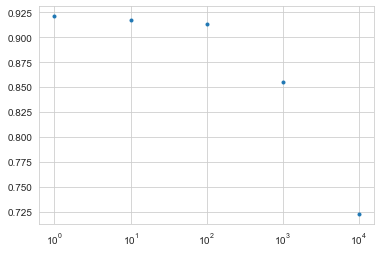

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.plot(ms, accuracies, '.')
plt.xscale('log')

## f) How would you game this model?
I would find every single word with a higher ham log-probability than spam log-probability and have a large number of them pasted into each of my spam emails in white text to ensure extremely low predicted probability of spam.